## Imports and functions ##

In [20]:
import os
import requests
import numpy as np

import torch
from torch import nn
from torch import optim
from skorch import NeuralNetClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

try:
    import importlib
    importlib.reload(stringer)
except NameError: # It hasn't been imported yet
    import Stringer_dataset_functions as stringer

## Download data #

In [ ]:
url = "https://osf.io/ny4ut/download"

## Upload data from repository ##
The data looks at the activity of ~20,000 neurons in the mouse primary visual cortex responding to oriented gratings recorded in [this study](https://www.biorxiv.org/content/10.1101/679324v2.abstract).

- ***data['sresp']:*** neurons by stimuli, a.k.a. the neural response data (23589 by 4598)
- ***data['xyz']:*** three-dimensional position of each neuron in the brain.
- ***data['run']:*** 1 by stimuli, a.k.a. the running speed of the animal in a.u.
- ***data['istim']:*** 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial
- ***data['u_spont']:*** neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm.
- ***data['v_spont']:*** 128 by 910, the timecourses for the top 128 PCs of spont activity.
- ***data['stat']:*** 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

Note that:
- ***data['u_spont'] @ data['v_spont']:*** will give a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.

**In the following cell, using some functions in the custom functions uploaded at the beginning of the notebook, I will:**
1. load the dataset
2. Z-score the neuronal activity using scikit-learn's StandardScaler
3. extract the neuronal responses ***(resp_all)*** anf the stimulus orientations ***(stimuli_all)*** for all neurons from all trials (i.e. stimulus presentation = trial)
4. extract the binned neuronal responses ***(resp_binned_avg)***, which is every neuron's average response to all the stimuli specified within a range of orientations (e.g. if ***bin_deg*** is set to 1, then there will be 360 responses for each neuron)

In [115]:
directory = r"C:\Users\61407\Neuronal-Calcium-Dynamics"
filename = "stringer_orientations.npy" #filename of the data
resp_all, resp_binned_avg, stimuli_all, stimuli_binned_avg, data = stringer.load_data(os.path.join(directory, filename),
                                                                                      bin_deg=1) #specify bin width
n_stimuli_binned, n_neurons = resp_binned_avg.shape

## EDA and data pre-processing ##

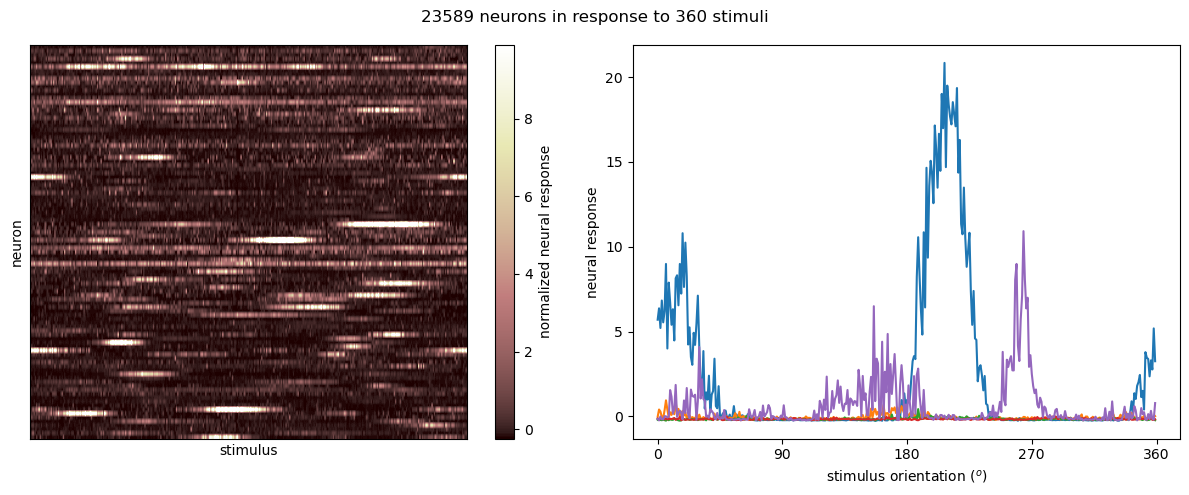

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6, 5))

# Visualize data matrix
stringer.plot_data_matrix(resp_binned_avg[:, :100].T, ax1)  # plot responses of first 100 neurons
ax1.set_xlabel('stimulus')
ax1.set_ylabel('neuron')

# Plot tuning curves of three random neurons
np.random.seed(0)
ineurons = np.random.choice(n_neurons, 5, replace=False)  # pick three random neurons
ax2.plot(list(range(resp_binned_avg.shape[0])), resp_binned_avg[:,ineurons])
ax2.set_xlabel('stimulus orientation ($^o$)')
ax2.set_ylabel('neural response')
ax2.set_xticks(np.linspace(0, resp_binned_avg.shape[0], 5))

fig.suptitle(f'{n_neurons} neurons in response to {n_stimuli_binned} stimuli')
fig.tight_layout()
plt.show()

C:\Users\61407\AppData\Local\Temp\ipykernel_15816\2824666545.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


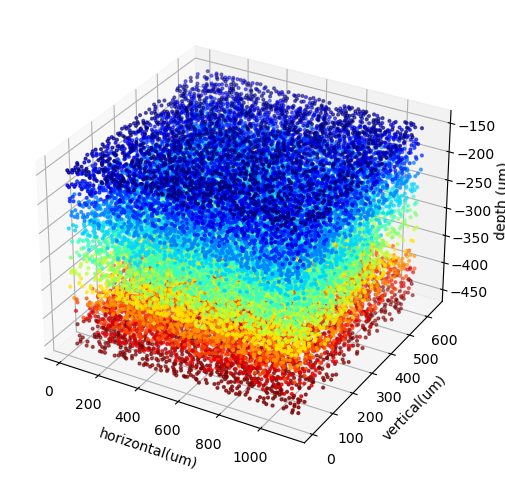

In [8]:
x, y, z = data['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1], y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

## Split data into train and test ##

In [9]:
X = resp_all
y = stimuli_all
n_stimuli = X.shape[0]

# Set random seeds for reproducibility
np.random.seed(4)
torch.manual_seed(4)

# Split data into training set and testing set
n_train = int(0.6 * n_stimuli)  # use 60% of all data for training set
ishuffle = torch.randperm(n_stimuli)
itrain = ishuffle[:n_train]  # indices of data samples to include in training set
itest = ishuffle[n_train:]  # indices of data samples to include in testing set
stimuli_test = y[itest]
resp_test = X[itest]
stimuli_train = y[itrain]
resp_train = X[itrain]

## Setup pytorch classifiers and randomized search CV ##
- Keeping it simple with a 2-layer network (i.e. 1 input layer, and 1 hidden layer with a RELU activation function)

In [13]:
class DeepNetReLU(nn.Module):
  """ network with a single hidden layer h with a RELU """

  def __init__(self, n_inputs, n_hidden):
    super().__init__()
    self.in_layer = nn.Linear(n_inputs, n_hidden) # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, 1) # hidden units --> output

  def forward(self, r):
    h = torch.relu(self.in_layer(r)) # h is size (n_inputs, n_hidden)
    y = self.out_layer(h) # y is size (n_inputs, 1)

    return y


def train(net, loss_fn, train_data, train_labels,
          n_epochs=200, learning_rate=1e-4):
  """Run gradient descent to optimize parameters of a given network

  Args:
    net (nn.Module): PyTorch network whose parameters to optimize
    loss_fn: built-in PyTorch loss function to minimize
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data
    n_epochs (int, optional): number of epochs of gradient descent to run
    learning_rate (float, optional): learning rate to use for gradient descent

  Returns:
    (list): training loss over iterations

  """

  # Initialize PyTorch SGD optimizer
  optimizer = optim.SGD(net.parameters(), lr=learning_rate)

  # Placeholder to save the loss at each iteration
  train_loss = []

  # Loop over epochs
  for i in range(n_epochs):

    # compute network output from inputs in train_data
    out = net(train_data)  # compute network output from inputs in train_data

    # evaluate loss function
    loss = loss_fn(out, train_labels)

    # Clear previous gradients
    optimizer.zero_grad()

    # Compute gradients
    loss.backward()

    # Update weights
    optimizer.step()

    # Store current value of loss
    train_loss.append(loss.item())  # .item() needed to transform the tensor output of loss_fn to a scalar


    # Track progress
    if (i + 1) % (n_epochs // 5) == 0:
      print(f'iteration {i + 1}/{n_epochs} | loss: {loss.item():.3f}')

  return train_loss

**Set the parameters for network training:**
- ***n_hidden (int)***: Number of units in the hidden layer
- ***loss_fn (pytorch nn obj)***: Specify the loss function you want to use
- ***n_epochs (int)***: Specify how many epochs you want to train your network on
- ***learning_rate (float)***: Specify the learning rate of your network

In [110]:
n_hidden = 50
loss_fn = nn.MSELoss()
n_epochs = 1000
learning_rate = 0.000001

- train the network!

In [111]:
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize network with 10 hidden units
net = DeepNetReLU(n_neurons, n_hidden)

# Run gradient descent on data
train_loss = train(net, loss_fn, resp_train, stimuli_train,
                   n_epochs, learning_rate)

iteration 200/1000 | loss: 6728.916
iteration 400/1000 | loss: 2911.761
iteration 600/1000 | loss: 2285.442
iteration 800/1000 | loss: 2012.971
iteration 1000/1000 | loss: 1832.748


- visualize how the network learnt!

Text(0, 0.5, 'MSE')

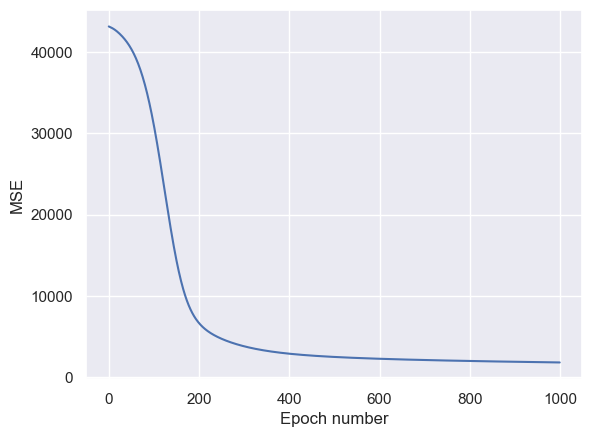

In [112]:
sns.set()
sns.lineplot(train_loss)
plt.xlabel('Epoch number')
plt.ylabel('MSE')

- predict the stimulus orientations using test data, and calculate error against actual orientations

In [113]:
ypred = net(resp_test)
loss_fn(stimuli_test, ypred)

tensor(1980.1302, grad_fn=<MseLossBackward0>)

- visualize the residuals

Text(0, 0.5, 'Residual')

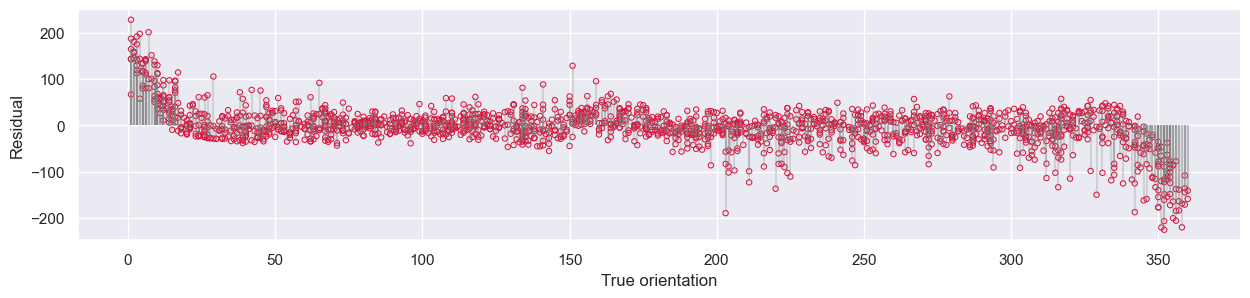

In [114]:
plt.figure(figsize=(15,3))
residuals = ypred - stimuli_test
plt.scatter(stimuli_test, residuals.detach().numpy(), edgecolor='crimson', facecolor='None', s=15, lw=0.75)
plt.vlines(stimuli_test, ymin=0, ymax=residuals.detach().numpy(), colors='grey', linestyle='-', alpha=0.25)
plt.xlabel('True orientation')
plt.ylabel('Residual')